In [1]:
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xarrayMannKendall import *

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:46681 Dashboard: /proxy/36535/status,Cluster Workers: 4 Cores: 16 Memory: 200.00 GiB


In [2]:
keys = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']

In [3]:
uas = {}
vas = {}
uas['ERA-Interim'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA-Interim'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['ERA5'] = xr.open_dataset('../data/uas-era5-monthly-1979_2015.nc')['u10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA5'] = xr.open_dataset('../data/vas-era5-monthly-1979_2015.nc')['v10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50))
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50))
uas['JRA55'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['JRA55'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

Load CMIP6 individual models

In [4]:
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_names = list(uas_cmip.keys())

Load region mask

In [5]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

Calculate area for weighting

In [6]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['ERA-Interim']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['ERA-Interim'].isel(time = 0)))
for i in range(len(uas['ERA-Interim']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['ERA-Interim']['lat'], 'lon':uas['ERA-Interim']['lon']})

In [7]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_names:
    u_ave[k] = (uas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [8]:
u_ave_xarray = u_ave[keys[0]]
v_ave_xarray = v_ave[keys[0]]
for k in keys[1:]+model_names:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = keys+model_names
v_ave_xarray['model'] = keys+model_names

In [9]:
uas_cmip_proj = {}; vas_cmip_proj = {}
uas_cmip_proj['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-2015_2100-ssp85.nc')['uas']
vas_cmip_proj['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-2015_2100-ssp85.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_cmip_proj[model_name] = xr.open_dataset(path_uas[i])['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_cmip_proj[model_name] = xr.open_dataset(path_vas[i])['vas']
model_names = list(uas_cmip_proj.keys())

In [10]:
u_ave_proj = {}
v_ave_proj = {}
for k in model_names:
    u_ave_proj[k] = (uas_cmip_proj[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_proj[k] = (vas_cmip_proj[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [11]:
u_ave_xarray_proj = u_ave_proj['CMIP6']
v_ave_xarray_proj = v_ave_proj['CMIP6']
for k in model_names[1:]:
    u_ave_xarray_proj = xr.concat([u_ave_xarray_proj, u_ave_proj[k]], dim = 'model')
    v_ave_xarray_proj = xr.concat([v_ave_xarray_proj, v_ave_proj[k]], dim = 'model')
u_ave_xarray_proj['model'] = model_names
v_ave_xarray_proj['model'] = model_names

In [12]:
u_sd_h = u_ave_xarray.sel(model = model_names[1:]).std('model')
v_sd_h = v_ave_xarray.sel(model = model_names[1:]).std('model')
u_sd_p = u_ave_xarray_proj.sel(model = model_names[1:]).std('model')
v_sd_p = v_ave_xarray_proj.sel(model = model_names[1:]).std('model')

In [13]:
u_cmip_complete = xr.concat([u_ave_xarray.sel(model = 'CMIP6'), u_ave_xarray_proj.sel(model = 'CMIP6')], dim = 'year')
v_cmip_complete = xr.concat([v_ave_xarray.sel(model = 'CMIP6'), v_ave_xarray_proj.sel(model = 'CMIP6')], dim = 'year')
usd_cmip_complete = xr.concat([u_sd_h, u_sd_p], dim = 'year')
vsd_cmip_complete = xr.concat([v_sd_h, v_sd_p], dim = 'year')

In [14]:
from palettable.tableau import Tableau_10

In [15]:
u_ave_xarray['model'][1:].values

array(['ERA5', 'CFSR', 'JRA55', 'CMIP6', 'INM-CM4-8', 'MRI-ESM2-0',
       'NESM3', 'IITM-ESM', 'INM-CM5-0', 'KACE-1-0-G', 'MPI-ESM1-2-HR',
       'GFDL-CM4', 'MIROC6', 'EC-Earth3-Veg-LR', 'MPI-ESM1-2-LR',
       'EC-Earth3-CC', 'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'AWI-CM-1-1-MR',
       'GFDL-ESM4', 'BCC-CSM2-MR', 'EC-Earth3', 'FGOALS-f3-L', 'CanESM5'],
      dtype='<U16')

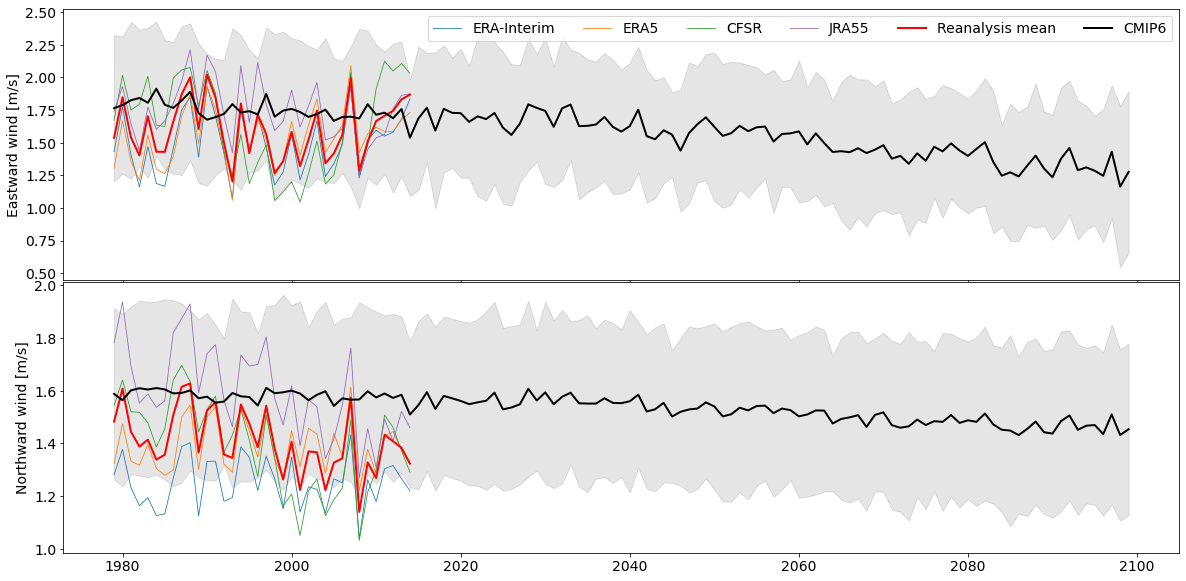

In [33]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
fig.subplots_adjust(hspace = 0.01)

for k, cl in zip(keys[:-1], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]]):
    ax1.plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = k), color = cl, linewidth = .8, label = k)
    ax2.plot(v_ave_xarray['year'], v_ave_xarray.sel(model = k), color = cl, linewidth = .8, label = k)
ax1.plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax1.plot(u_cmip_complete['year'], -u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
ax1.fill_between(u_cmip_complete['year'], -u_cmip_complete+usd_cmip_complete, -u_cmip_complete-usd_cmip_complete, color = 'k', alpha = 0.1)
ax1.set_ylabel('Eastward wind [m/s]')
ax1.legend(ncol = 6)
ax2.plot(v_ave_xarray['year'], v_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax2.plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
ax2.fill_between(v_cmip_complete['year'], v_cmip_complete-vsd_cmip_complete, v_cmip_complete+vsd_cmip_complete, color = 'k', alpha = 0.1)
ax2.set_ylabel('Northward wind [m/s]')

plt.savefig('../results/v3/fig4.jpg', bbox_inches = 'tight')

In [16]:
u_ave_cmip = {}
v_ave_cmip = {}
for k in u_ave_xarray_proj['model'][1:].values:
    u_ave_cmip[k] = xr.concat([u_ave_xarray.sel(model = k), u_ave_xarray_proj.sel(model = k)], dim = 'year')
    v_ave_cmip[k] = xr.concat([v_ave_xarray.sel(model = k), v_ave_xarray_proj.sel(model = k)], dim = 'year')

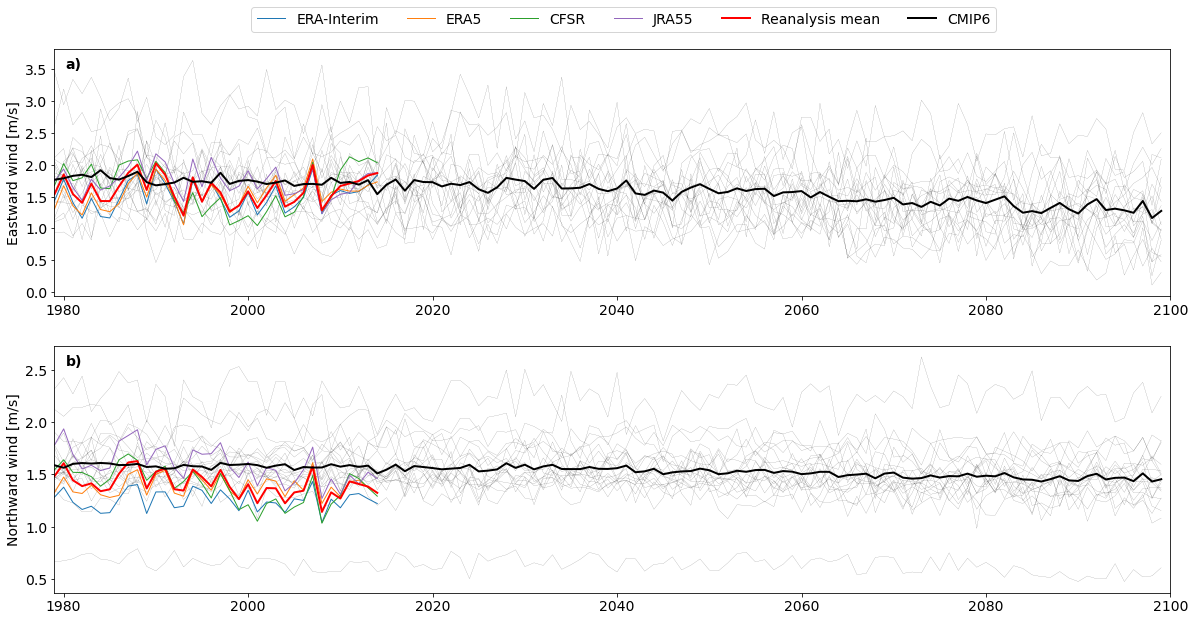

In [24]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
ax1.set_xlim(1979, 2100)
#fig.subplots_adjust(hspace = 0.01)
ax1.text(0.01, .92, 'a)', transform = ax1.transAxes, size = 14, weight = 'bold')
ax2.text(0.01, .92, 'b)', transform = ax2.transAxes, size = 14, weight = 'bold')
for k in u_ave_xarray_proj['model'][1:].values:
    ax1.plot(u_ave_cmip[k]['year'], -u_ave_cmip[k], color = 'k', linewidth = .1)
    ax2.plot(v_ave_cmip[k]['year'], v_ave_cmip[k], color = 'k', linewidth = .1)
for k, cl in zip(keys[:-1], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]]):
    ax1.plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = k), color = cl, linewidth = 1, label = k)
    ax2.plot(v_ave_xarray['year'], v_ave_xarray.sel(model = k), color = cl, linewidth = 1, label = k)
ax1.plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax1.plot(u_cmip_complete['year'], -u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
ax1.set_ylabel('Eastward wind [m/s]')
ax1.legend(ncol = 6, bbox_to_anchor = (.85, 1.2))
ax2.plot(v_ave_xarray['year'], v_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax2.plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
ax2.set_ylabel('Northward wind [m/s]')

plt.savefig('../results/v3/fig4-spaguetti.jpg', bbox_inches = 'tight')

# Quantify trends

In [61]:
keys+list(u_ave_xarray_proj['model'][1:].values)

['ERA-Interim',
 'ERA5',
 'CFSR',
 'JRA55',
 'CMIP6',
 'INM-CM5-0',
 'KACE-1-0-G',
 'MRI-ESM2-0',
 'IPSL-CM6A-LR',
 'NESM3',
 'BCC-CSM2-MR',
 'MPI-ESM1-2-HR',
 'EC-Earth3',
 'AWI-CM-1-1-MR',
 'CanESM5',
 'FGOALS-f3-L',
 'MIROC6',
 'EC-Earth3-Veg-LR',
 'IITM-ESM',
 'GFDL-ESM4',
 'EC-Earth3-CC',
 'MPI-ESM1-2-LR',
 'GFDL-CM4',
 'INM-CM4-8',
 'EC-Earth3-Veg']

In [46]:
import scipy.stats as st

In [67]:
u_trend_hist = xr.DataArray(np.empty(5), dims = 'model', coords = {'model':keys})

In [51]:
for k in keys[:-1]:
    print(k)
    lr = st.linregress(np.arange(0, len(u_ave_xarray['year']), 1), -u_ave_xarray.sel(model = k).values)
    u_trend_hist.sel(model = k).values = lr.slope
    up_trend_hist.sel(model = k).values = lr.pvalue

ERA-Interim
LinregressResult(slope=0.0034306578001280434, intercept=1.4351068871144794, rvalue=0.15333693075652297, pvalue=0.37193812673366533, stderr=0.003791618062560379, intercept_stderr=0.07716354203664912)
ERA5
LinregressResult(slope=0.006480676233283804, intercept=1.435380351803844, rvalue=0.31001767126127006, pvalue=0.06575498037424955, stderr=0.0034084111553124544, intercept_stderr=0.06936486563826949)
CFSR
LinregressResult(slope=-0.00425299764077824, intercept=1.7068608957065177, rvalue=-0.12586891502640718, pvalue=0.4644875443360472, stderr=0.005748696635880927, intercept_stderr=0.11699221472196408)
JRA55
LinregressResult(slope=-0.004548379061365135, intercept=1.8281588902897745, rvalue=-0.21162350602199115, pvalue=0.21533788128046286, stderr=0.003602499809248069, intercept_stderr=0.07331478036060947)
CMIP6
LinregressResult(slope=-0.003980470295158889, intercept=1.8190018541462427, rvalue=-0.5906734906633138, pvalue=0.00014909628311380978, stderr=0.000932551674374438, interce

In [54]:
print('CMIP6')
lr = st.linregress(np.arange(0, len(u_cmip_complete['year']), 1), -u_cmip_complete.values)
print(lr)

CMIP6
LinregressResult(slope=-0.004400836554930893, intercept=1.8547094982936554, rvalue=-0.90205649570715, pvalue=3.048218120924236e-45, stderr=0.0001930312157149307, intercept_stderr=0.013401427616438907)


In [53]:
for k in u_ave_xarray_proj['model'][1:].values:
    print(k)
    lr = st.linregress(np.arange(0, len(u_ave_cmip[k]['year']), 1), -u_ave_cmip[k].values)
    print(lr)

INM-CM5-0
LinregressResult(slope=-0.003645002577533272, intercept=1.84515360827002, rvalue=-0.42221867779328603, pvalue=1.4090289367751695e-06, stderr=0.0007173842800624082, intercept_stderr=0.04980527873080102)
KACE-1-0-G
LinregressResult(slope=-0.004080728464630374, intercept=1.3823341960067081, rvalue=-0.4855953599599851, pvalue=1.6472156734606542e-08, stderr=0.0006734298989077779, intercept_stderr=0.04675369220223116)
MRI-ESM2-0
LinregressResult(slope=-0.0020596517023325463, intercept=2.62695034447901, rvalue=-0.2319655453572454, pvalue=0.010462538295556763, stderr=0.0007917470514055861, intercept_stderr=0.05496800484130291)
IPSL-CM6A-LR
LinregressResult(slope=-0.003255219497872276, intercept=1.917464802213873, rvalue=-0.4576769674814929, pvalue=1.3069472469921286e-07, stderr=0.000579705486627081, intercept_stderr=0.0402467605517153)
NESM3
LinregressResult(slope=-0.004941403761921251, intercept=1.7382717458026615, rvalue=-0.46318978712347625, pvalue=8.80921963876807e-08, stderr=0.0